## Setup

In [1]:
%matplotlib inline

In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo
from aif360.metrics import BinaryLabelDatasetMetric
from oversample import label_bias, selection_bias 
from sklearn import preprocessing
from privacy_meter.dataset import Dataset
from aif360.datasets import BinaryLabelDataset
import os
import shutil
import glob
from datetime import datetime

## Arguments & Initializations

In [3]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex', 'law_race', 'law_aif_gender', 'law_aif_race'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [4]:
sys.argv = ['']
args = vars(ap.parse_args())

In [5]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [6]:
DATASET = "adult_race"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = 2
ATTACK = "mia1"

In [7]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# cpp_metrics = defaultdict(list) 
# cpp_mia_metrics = defaultdict(list)

# pr_orig_metrics = defaultdict(list) 
# ro_metrics = defaultdict(list) 

In [8]:
# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [9]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\algorithms\preprocessing\optim_preproc_helpers\data_preproc_functions.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'Female': 0.0, 'Male': 1.0})


In [10]:
df, _ = dataset_orig.convert_to_dataframe()

In [11]:
dataset_orig.features.shape

(48842, 18)

In [12]:
privileged_groups

[{'race': 1}]

In [13]:
sens_attr

'race'

In [14]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [15]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

[[1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]]
no bias type specified


## Run Mitigating Algorithms

### Setup for MIA2

In [16]:
seed = 1234
np.random.seed(seed)

In [17]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [18]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)
    
    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [19]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [20]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [21]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [22]:
# target_dataset = None
# reference_dataset = None

In [23]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
def prepare_datasets():
    target_dataset = None
    reference_dataset = None
    
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()

        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2

        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)

        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
#         dataset_orig_val = create_binary_label_dataset(
#             dataset_orig=dataset_orig,
#             X=X[valid_index],
#             y=y_true[valid_index],
#             sensitive_features=sensitive_features[valid_index],
#             sens_attr_name=sens_attr,
#             privileged_value=privileged_value,
#             unprivileged_value=unprivileged_value
#         )

        # Convert test dataset
        dataset_orig_test = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        dataset_orig_val = dataset_orig_test
        
    return dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset

In [25]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

try:
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()
except ValueError as e:
    print("Error detected: No samples generated. Adjusting datasets...")
    delete_logs()
    # percentage of favor and unfavor
    priv_metric_orig = defaultdict(float)
    favor_metric_orig = defaultdict(float)
    favor_metric_transf = defaultdict(float)

    # for each pre-processing approach, we create a mia_metric_results
    orig_metrics = defaultdict(list)
    orig_mia_metrics = defaultdict(list)

    transf_metrics = defaultdict(list) 
    transf_mia_metrics = defaultdict(list) 

    reweigh_metrics = defaultdict(list) 
    reweigh_mia_metrics = defaultdict(list) 

    dir_metrics = defaultdict(list) 
    dir_mia_metrics = defaultdict(list) 

    eg_metrics = defaultdict(list) 
    eg_mia_metrics = defaultdict(list) 
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        while(base_rate_privileged >= base_rate_unprivileged and (base_rate_privileged - base_rate_unprivileged) <= 0.05):
            print("DIFFERENCE IS TOO LOW, GETTING DATASETS AGAIN")
            dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()
             # check fairness on the original data
            metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                         unprivileged_groups=unprivileged_groups,
                                                         privileged_groups=privileged_groups)
            print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
            base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
            base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
        print("ORIG MIA METRICS ", orig_mia_metrics)
        
        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()

ITERATION  0
privileged vs. unprivileged:  20813.0 3608.0
base_pos unpriv:  0.14772727272727273
base_pos priv:  0.2557055686349877
DIFFERENCE IS GOOD
base_pos unpriv:  0.14772727272727273
base_pos priv:  0.2557055686349877
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5855
Difference in mean outcomes between unprivileged and pr

Number of training samples (ntrain): 15491
Number of test samples (ntest): 15664
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5322
Number of test samples (ntest): 5285
TEST
Best thresh:  0.28
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -1.4390267117350617
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18566, Test = 18589
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.5256925351063243
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5855, Test = 5832
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train

ITERATION  1
privileged vs. unprivileged:  20907.0 3514.0
base_pos unpriv:  0.1476949345475242
base_pos priv:  0.2524513320897307
DIFFERENCE IS GOOD
base_pos unpriv:  0.1476949345475242
base_pos priv:  0.2524513320897307
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5797
Difference in mean outcomes between unprivileged and priv

Number of training samples (ntrain): 15629
Number of test samples (ntest): 15526
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5278
Number of test samples (ntest): 5329
TEST
Best thresh:  0.24000000000000002
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.31
  Test Accuracy (TNR): 0.70
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.08004270767353637
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18624, Test = 18531
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.40
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.07889394246966308
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5797, Test = 5890
  AUC: 0.50
  Privacy Risk: 0.50
  Accur

ITERATION  2
privileged vs. unprivileged:  20871.0 3550.0
base_pos unpriv:  0.15690140845070422
base_pos priv:  0.25442000862440706
DIFFERENCE IS GOOD
base_pos unpriv:  0.15690140845070422
base_pos priv:  0.25442000862440706
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5867
Difference in mean outcomes between unprivileged and 

Number of training samples (ntrain): 15561
Number of test samples (ntest): 15594
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5310
Number of test samples (ntest): 5297
TEST
Best thresh:  0.29000000000000004
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.28
  Test Accuracy (TNR): 0.73
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.06431204621870032
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18554, Test = 18601
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.37
  Test Accuracy (TNR): 0.64
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.06431204621870032
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5867, Test = 5820
  AUC: 0.50
  Privacy Risk: 0.50
  Accur

ITERATION  3
privileged vs. unprivileged:  20811.0 3610.0
base_pos unpriv:  0.1520775623268698
base_pos priv:  0.25731584258324924
DIFFERENCE IS GOOD
base_pos unpriv:  0.1520775623268698
base_pos priv:  0.25731584258324924
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5904
Difference in mean outcomes between unprivileged and pr

Number of training samples (ntrain): 15456
Number of test samples (ntest): 15699
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5355
Number of test samples (ntest): 5252
TEST
Best thresh:  0.23
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.59
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.3378302405644229
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18517, Test = 18638
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.51
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.12516314295400605
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5904, Test = 5783
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.50
  Trai

ITERATION  4
privileged vs. unprivileged:  20925.0 3496.0
base_pos unpriv:  0.1507437070938215
base_pos priv:  0.2565352449223417
DIFFERENCE IS GOOD
base_pos unpriv:  0.1507437070938215
base_pos priv:  0.2565352449223417
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5895
Difference in mean outcomes between unprivileged and priv

Number of training samples (ntrain): 15557
Number of test samples (ntest): 15598
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5368
Number of test samples (ntest): 5239
TEST
Best thresh:  0.29000000000000004
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.32
  Test Accuracy (TNR): 0.69
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.07669262078825445
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18526, Test = 18629
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.07669262078825445
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5895, Test = 5792
  AUC: 0.50
  Privacy Risk: 0.51
  Accur

ITERATION  5
privileged vs. unprivileged:  20914.0 3507.0
base_pos unpriv:  0.15112631879098945
base_pos priv:  0.25356220713397726
DIFFERENCE IS GOOD
base_pos unpriv:  0.15112631879098945
base_pos priv:  0.25356220713397726
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5833
Difference in mean outcomes between unprivileged and 

Number of training samples (ntrain): 15611
Number of test samples (ntest): 15544
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5303
Number of test samples (ntest): 5304
TEST
Best thresh:  0.21000000000000002
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.00
  Positive predictive value: 0.51
  Optimal thershold: -0.7644434767906132
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18588, Test = 18567
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.4232860046782758
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5833, Test = 5854
  AUC: 0.50
  Privacy Risk: 0.50
  Accurac

ITERATION  6
privileged vs. unprivileged:  20941.0 3480.0
base_pos unpriv:  0.14396551724137932
base_pos priv:  0.2549543956831097
DIFFERENCE IS GOOD
base_pos unpriv:  0.14396551724137932
base_pos priv:  0.2549543956831097
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5840
Difference in mean outcomes between unprivileged and pr

Number of training samples (ntrain): 15602
Number of test samples (ntest): 15553
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5339
Number of test samples (ntest): 5268
TEST
Best thresh:  0.2
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.00
  Positive predictive value: 0.50
  Optimal thershold: -1.1648160891247423
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18581, Test = 18574
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.00
  Positive predictive value: 0.50
  Optimal thershold: -0.21357410029805904
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5840, Test = 5847
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train

ITERATION  7
privileged vs. unprivileged:  20879.0 3542.0
base_pos unpriv:  0.15160926030491248
base_pos priv:  0.2515446142056612
DIFFERENCE IS GOOD
base_pos unpriv:  0.15160926030491248
base_pos priv:  0.2515446142056612
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5789
Difference in mean outcomes between unprivileged and pr

Number of training samples (ntrain): 15627
Number of test samples (ntest): 15528
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5252
Number of test samples (ntest): 5355
TEST
Best thresh:  0.23
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.36987416300546183
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18632, Test = 18523
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 0.66
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.05480823649499503
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5789, Test = 5898
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Tra

ITERATION  8
privileged vs. unprivileged:  20818.0 3603.0
base_pos unpriv:  0.1482098251457119
base_pos priv:  0.25405898741473726
DIFFERENCE IS GOOD
base_pos unpriv:  0.1482098251457119
base_pos priv:  0.25405898741473726
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5823
Difference in mean outcomes between unprivileged and pr

Number of training samples (ntrain): 15529
Number of test samples (ntest): 15626
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5289
Number of test samples (ntest): 5318
TEST
Best thresh:  0.24000000000000002
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.8189165678489787
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18598, Test = 18557
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.21
  Test Accuracy (TNR): 0.80
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.03390155167568134
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5823, Test = 5864
  AUC: 0.52
  Privacy Risk: 0.52
  Accura

ITERATION  9
privileged vs. unprivileged:  20912.0 3509.0
base_pos unpriv:  0.1555998860074095
base_pos priv:  0.2566469013006886
DIFFERENCE IS GOOD
base_pos unpriv:  0.1555998860074095
base_pos priv:  0.2566469013006886
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5913
Difference in mean outcomes between unprivileged and priv

Number of training samples (ntrain): 15545
Number of test samples (ntest): 15610
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5367
Number of test samples (ntest): 5240
TEST
Best thresh:  0.29000000000000004
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.00
  Positive predictive value: 0.51
  Optimal thershold: -0.36791169601371204
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18508, Test = 18647
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.3425932092213683
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5913, Test = 5774
  AUC: 0.50
  Privacy Risk: 0.51
  Accura

ITERATION  10
privileged vs. unprivileged:  20878.0 3543.0
base_pos unpriv:  0.16116285633643804
base_pos priv:  0.25395152792413067
DIFFERENCE IS GOOD
base_pos unpriv:  0.16116285633643804
base_pos priv:  0.25395152792413067
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5873
Difference in mean outcomes between unprivileged and

Number of training samples (ntrain): 15576
Number of test samples (ntest): 15579
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5302
Number of test samples (ntest): 5305
TEST
Best thresh:  0.28
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.41
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.00
  Positive predictive value: 0.50
  Optimal thershold: -0.13696585507315742
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18548, Test = 18607
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.54
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.13696585507315742
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5873, Test = 5814
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Tra

ITERATION  11
privileged vs. unprivileged:  20888.0 3533.0
base_pos unpriv:  0.1508632889895273
base_pos priv:  0.2551225584067407
DIFFERENCE IS GOOD
base_pos unpriv:  0.1508632889895273
base_pos priv:  0.2551225584067407
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5862
Difference in mean outcomes between unprivileged and pri

Number of training samples (ntrain): 15559
Number of test samples (ntest): 15596
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5329
Number of test samples (ntest): 5278
TEST
Best thresh:  0.24000000000000002
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.08
  Test Accuracy (TNR): 0.93
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.010221554071538028
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18559, Test = 18596
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.10
  Test Accuracy (TNR): 0.90
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.010221554071538028
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5862, Test = 5825
  AUC: 0.49
  Privacy Risk: 0.50
  Acc

ITERATION  12
privileged vs. unprivileged:  20886.0 3535.0
base_pos unpriv:  0.15162659123055164
base_pos priv:  0.25553002010916404
DIFFERENCE IS GOOD
base_pos unpriv:  0.15162659123055164
base_pos priv:  0.25553002010916404
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5873
Difference in mean outcomes between unprivileged and

Number of training samples (ntrain): 15549
Number of test samples (ntest): 15606
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5337
Number of test samples (ntest): 5270
TEST
Best thresh:  0.22
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.18
  Test Accuracy (TNR): 0.83
  Attacker advantage: 0.00
  Positive predictive value: 0.50
  Optimal thershold: -0.04546237407675729
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18548, Test = 18607
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.23
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.00
  Positive predictive value: 0.50
  Optimal thershold: -0.04546237407675729
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5873, Test = 5814
  AUC: 0.49
  Privacy Risk: 0.50
  Accuracy: 0.51
  Tra

ITERATION  13
privileged vs. unprivileged:  20900.0 3521.0
base_pos unpriv:  0.14768531667140017
base_pos priv:  0.25473684210526315
DIFFERENCE IS GOOD
base_pos unpriv:  0.14768531667140017
base_pos priv:  0.25473684210526315
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5844
Difference in mean outcomes between unprivileged and

Number of training samples (ntrain): 15576
Number of test samples (ntest): 15579
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5324
Number of test samples (ntest): 5283
TEST
Best thresh:  0.25
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.18
  Test Accuracy (TNR): 0.83
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.04445176257083381
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18577, Test = 18578
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.23
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.04445176257083381
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5844, Test = 5843
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Tra

ITERATION  14
privileged vs. unprivileged:  20894.0 3527.0
base_pos unpriv:  0.15707400056705415
base_pos priv:  0.25514501770843306
DIFFERENCE IS GOOD
base_pos unpriv:  0.15707400056705415
base_pos priv:  0.25514501770843306
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5885
Difference in mean outcomes between unprivileged and

Number of training samples (ntrain): 15563
Number of test samples (ntest): 15592
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5331
Number of test samples (ntest): 5276
TEST
Best thresh:  0.23
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -1.1640561969204934
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18536, Test = 18619
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.43
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.00
  Positive predictive value: 0.50
  Optimal thershold: -0.09844007281325252
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5885, Test = 5802
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Trai

ITERATION  15
privileged vs. unprivileged:  20903.0 3518.0
base_pos unpriv:  0.14638999431495167
base_pos priv:  0.25833612400133954
DIFFERENCE IS GOOD
base_pos unpriv:  0.14638999431495167
base_pos priv:  0.25833612400133954
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5915
Difference in mean outcomes between unprivileged and

Number of training samples (ntrain): 15503
Number of test samples (ntest): 15652
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5400
Number of test samples (ntest): 5207
TEST
Best thresh:  0.23
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.44
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.28039416929418964
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18506, Test = 18649
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.27625337662815824
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5915, Test = 5772
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Tra

ITERATION  16
privileged vs. unprivileged:  20898.0 3523.0
base_pos unpriv:  0.1518592108998013
base_pos priv:  0.2531342712221265
DIFFERENCE IS GOOD
base_pos unpriv:  0.1518592108998013
base_pos priv:  0.2531342712221265
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5825
Difference in mean outcomes between unprivileged and pri

Number of training samples (ntrain): 15608
Number of test samples (ntest): 15547
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5290
Number of test samples (ntest): 5317
TEST
Best thresh:  0.24000000000000002
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.22
  Test Accuracy (TNR): 0.78
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.05715841383994864
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18596, Test = 18559
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.29
  Test Accuracy (TNR): 0.71
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.05715841383994864
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5825, Test = 5862
  AUC: 0.50
  Privacy Risk: 0.51
  Accur

ITERATION  17
privileged vs. unprivileged:  20825.0 3596.0
base_pos unpriv:  0.14655172413793102
base_pos priv:  0.2574789915966387
DIFFERENCE IS GOOD
base_pos unpriv:  0.14655172413793102
base_pos priv:  0.2574789915966387
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5889
Difference in mean outcomes between unprivileged and p

Number of training samples (ntrain): 15463
Number of test samples (ntest): 15692
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5362
Number of test samples (ntest): 5245
TEST
Best thresh:  0.3
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.08
  Test Accuracy (TNR): 0.92
  Attacker advantage: 0.01
  Positive predictive value: 0.52
  Optimal thershold: -0.006920442844573795
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18532, Test = 18623
  AUC: 0.51
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 0.11
  Test Accuracy (TNR): 0.90
  Attacker advantage: 0.01
  Positive predictive value: 0.52
  Optimal thershold: -0.006920442844573795
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5889, Test = 5798
  AUC: 0.49
  Privacy Risk: 0.51
  Accuracy: 0.51
  Tr

ITERATION  18
privileged vs. unprivileged:  20855.0 3566.0
base_pos unpriv:  0.1519910263600673
base_pos priv:  0.2552865020378806
DIFFERENCE IS GOOD
base_pos unpriv:  0.1519910263600673
base_pos priv:  0.2552865020378806
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5866
Difference in mean outcomes between unprivileged and pri

Number of training samples (ntrain): 15531
Number of test samples (ntest): 15624
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5324
Number of test samples (ntest): 5283
TEST
Best thresh:  0.27
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.18
  Test Accuracy (TNR): 0.83
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.04652001563489282
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18555, Test = 18600
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.23
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.04652001563489282
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5866, Test = 5821
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Tra

ITERATION  19
privileged vs. unprivileged:  20886.0 3535.0
base_pos unpriv:  0.14512022630834512
base_pos priv:  0.25572153595710045
DIFFERENCE IS GOOD
base_pos unpriv:  0.14512022630834512
base_pos priv:  0.25572153595710045
no bias type specified
#### Training Dataset shape
(24421, 18)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
number of favorable labels:  5854
Difference in mean outcomes between unprivileged and

Number of training samples (ntrain): 15545
Number of test samples (ntest): 15610
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5341
Number of test samples (ntest): 5266
TEST
Best thresh:  0.2
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -1.0986122886681098
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 18567, Test = 18588
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.11
  Test Accuracy (TNR): 0.89
  Attacker advantage: 0.00
  Positive predictive value: 0.51
  Optimal thershold: -0.01388911216066715
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 5854, Test = 5833
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train

## Display Output

In [26]:
priv_metric_orig_copy = priv_metric_orig

In [27]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 417604.0, 'total_unpriv': 70816.0})

In [28]:
priv_metric_orig

defaultdict(float, {'total_priv': 417604.0, 'total_unpriv': 70816.0})

In [29]:
priv_metric_orig.items()

dict_items([('total_priv', 417604.0), ('total_unpriv', 70816.0)])

In [30]:
priv_metric_orig = priv_metric_orig_copy

In [31]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

adult_race
24421
2)

              total_priv  total_unpriv
num_instance                          
orig             20880.2        3540.8
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.239962       0.760038    0.255082      0.744918      0.150799   
transf      0.255068       0.744932    0.255082      0.744918      0.254993   

         unpriv_unfavor  
dataset                  
orig           0.849201  
transf         0.745007  


# Train/Test Accuracies

In [32]:
def separate_metrics(metrics):
    accuracy_metrics = defaultdict(list)

    # List of accuracy-related keys
    accuracy_keys = [
        'accuracy_train_0_-', 'accuracy_train_0_+',
        'accuracy_train_1_-', 'accuracy_train_1_+',
        'accuracy_test_0_-', 'accuracy_test_0_+',
        'accuracy_test_1_-', 'accuracy_test_1_+',
        'accuracy_train', 'accuracy_test'
    ]

    # Separate accuracy metrics into a new dictionary
    for key in accuracy_keys:
        if key in metrics:
            accuracy_metrics[key] = metrics.pop(key)

    return metrics, accuracy_metrics

In [33]:
orig_metrics, orig_acc = separate_metrics(orig_metrics)
transf_metrics, transf_acc = separate_metrics(transf_metrics)
reweigh_metrics, reweigh_acc = separate_metrics(reweigh_metrics)
dir_metrics, dir_acc = separate_metrics(dir_metrics)
eg_metrics, eg_acc = separate_metrics(eg_metrics)

In [34]:
def calculate_mean_accuracy(acc_metrics):
    mean_accuracies = {key: sum(values) / len(values) for key, values in acc_metrics.items()}
    return mean_accuracies

In [35]:
orig_acc_mean = calculate_mean_accuracy(orig_acc)
transf_acc_mean = calculate_mean_accuracy(transf_acc)
reweigh_acc_mean = calculate_mean_accuracy(reweigh_acc)
dir_acc_mean = calculate_mean_accuracy(dir_acc)
eg_acc_mean = calculate_mean_accuracy(eg_acc)

# Display the results
train_test_data = {
    "orig_acc_mean": orig_acc_mean,
    "transf_acc_mean": transf_acc_mean,
    "reweigh_acc_mean": reweigh_acc_mean,
    "dir_acc_mean": dir_acc_mean,
    "eg_acc_mean": eg_acc_mean
}

## Save Data

In [36]:
# Convert dictionary to DataFrame
train_test_df = pd.DataFrame(train_test_data)

# File path
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./mia1_results/{ATTACK}_{DATASET}_train_test_accuracies_{today}.csv"

# Save to CSV
train_test_df.to_csv(file_path, index=True)

file_path

'./mia1_results/mia1_adult_race_train_test_accuracies_2024-12-31.csv'

In [37]:
train_test_df

,orig_acc_mean,transf_acc_mean,reweigh_acc_mean,dir_acc_mean,eg_acc_mean
accuracy_train_0_-,0.974131,0.963594,0.923705,0.974131,0.926769
accuracy_train_0_+,0.237509,0.485835,0.462302,0.237509,0.409487
accuracy_train_1_-,0.923370,0.927541,0.927250,0.923370,0.925621
accuracy_train_1_+,0.416137,0.401974,0.404400,0.416137,0.409561
accuracy_test_0_-,0.973971,0.962955,0.922094,0.973971,0.926577
accuracy_test_0_+,0.242484,0.254132,0.455369,0.242484,0.404946
accuracy_test_1_-,0.922876,0.927719,0.927049,0.922876,0.925240
accuracy_test_1_+,0.413895,0.401349,0.402789,0.413895,0.407723
accuracy_train,0.804011,0.801302,0.802633,0.804011,0.801783
accuracy_test,0.803839,0.803147,0.802500,0.803839,0.802015


In [38]:
train_test_df.head()

,orig_acc_mean,transf_acc_mean,reweigh_acc_mean,dir_acc_mean,eg_acc_mean
accuracy_train_0_-,0.974131,0.963594,0.923705,0.974131,0.926769
accuracy_train_0_+,0.237509,0.485835,0.462302,0.237509,0.409487
accuracy_train_1_-,0.923370,0.927541,0.927250,0.923370,0.925621
accuracy_train_1_+,0.416137,0.401974,0.404400,0.416137,0.409561
accuracy_test_0_-,0.973971,0.962955,0.922094,0.973971,0.926577


In [39]:
%matplotlib inline
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
# from scipy.stats import ttest_rel
# def paired_t (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
#     return p

# def acc_diff (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     delta = np_a - np_b
#     m = statistics.mean(delta)
#     s = statistics.stdev(delta)
#     return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

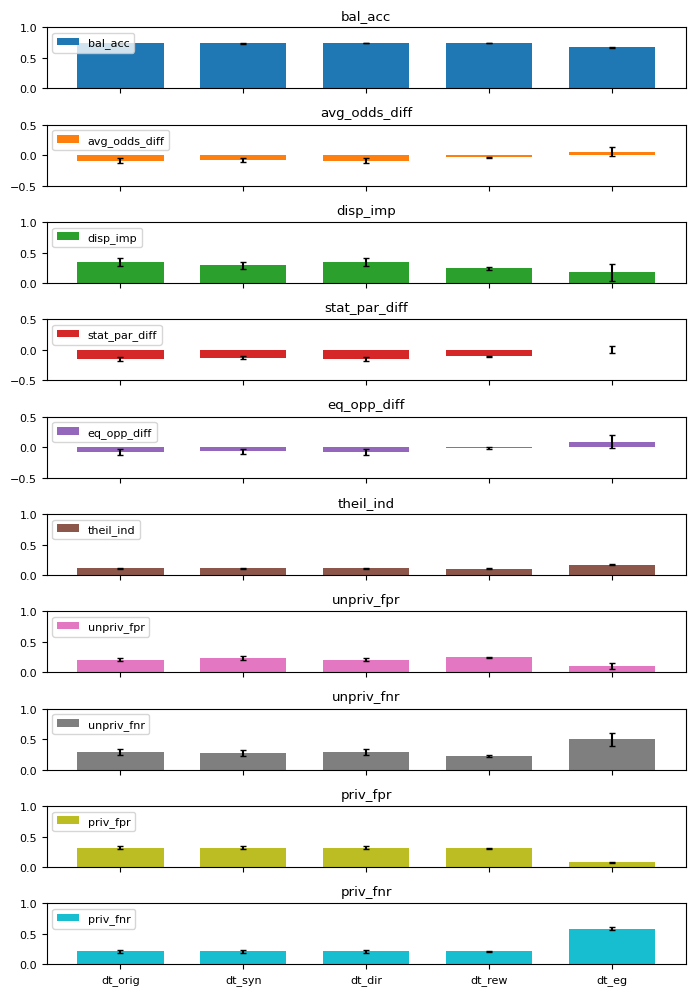

In [40]:
model_type=BASELINE
# Set up plotting options
plt.rcParams.update({'font.size': 8})  # Set global font size
pd.set_option('display.multi_sparse', False)

# Metrics and errors as lists of dictionaries
results = [orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean]
errors = [orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics]

# Classifier bias mitigators (for labels)
index = pd.Series(
    [model_type+'_orig', model_type+'_syn', model_type+'_dir', model_type+'_rew', model_type+'_eg'])

# Create DataFrame for metrics and error bars
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)

# Dynamically generate titles for all metrics in df
titles = list(df.columns)

# Plot fairness metrics with error bars
ax = df.plot.bar(
    yerr=df_error, 
    capsize=2, 
    rot=0, 
    subplots=True, 
    title=titles, 
    fontsize=8, 
    figsize=(7, 10),  # Reduced overall figure size
    legend=True,
    width=0.7  # Adjusted bar width to make bars closer
)

# Adjust Y-axis limits dynamically based on metric names
for i, subplot in enumerate(ax):
    metric = titles[i]
    if "fpr" in metric or "fnr" in metric:  # Subgroup-specific metrics
        subplot.set_ylim([0, 1])  # False positive/negative rates range from 0 to 1
    elif metric in ["bal_acc", "disp_imp", "theil_ind"]:  # General metrics
        subplot.set_ylim([0, 1])
    elif metric in ["avg_odds_diff", "stat_par_diff", "eq_opp_diff"]:  # Difference metrics
        subplot.set_ylim([-0.5, 0.5])  # Allow for negative values

    # Move legend inside the plot
    subplot.legend(loc='upper left', fontsize=8, frameon=True)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

## Save Results

In [41]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
fairness_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        fairness_data.append({
            "Method": method,
            "Metric": key,
            "Mean": metric[key][0],  # Assuming the metric values are single-item lists
            "Error": error[key][0]   # Assuming the error values are single-item lists
        })

# Create DataFrame from the data list
fairness_df = pd.DataFrame(fairness_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./mia1_results/{ATTACK}_{DATASET}_fairness_metrics_{today}.csv"

# Save the DataFrame to CSV
fairness_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./mia1_results/mia1_adult_race_fairness_metrics_2024-12-31.csv


## Visualization of MIA results


### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [42]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [43]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.502965,0.503672,0.507241,0.509093,0.523167,0.503469,0.506376
syn,0.502698,0.503319,0.506679,0.508627,0.522313,0.503229,0.505975
dir,0.502964,0.503671,0.507241,0.509083,0.523167,0.503469,0.506376
rew,0.502774,0.503452,0.506976,0.508987,0.522092,0.503344,0.506549
eg,0.502657,0.503331,0.506852,0.507636,0.521049,0.503520,0.506540


In [44]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [45]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
                       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [46]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.509093,0.503469,0.523167,0.506376
syn,0.508627,0.503229,0.522313,0.505975
dir,0.509083,0.503469,0.523167,0.506376
rew,0.508987,0.503344,0.522092,0.506549
eg,0.507636,0.503520,0.521049,0.506540


<Axes: xlabel='Classifier MIA Attacks'>

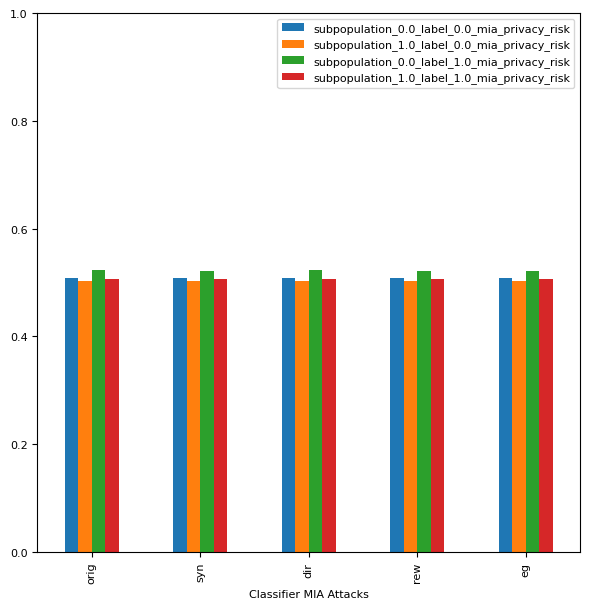

In [47]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [48]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.509093  0.508627  0.509083  0.508987  0.507636
subpopulation_1.0_label_0.0_mia_privacy_risk  0.503469  0.503229  0.503469  0.503344  0.50352
subpopulation_0.0_label_1.0_mia_privacy_risk  0.523167  0.522313  0.523167  0.522092  0.521049
subpopulation_1.0_label_1.0_mia_privacy_risk  0.506376  0.505975  0.506376  0.506549  0.50654


## Save Results

In [49]:
errors

[{'entire_dataset_mia_privacy_risk': 0.001237373282083869,
  'entire_dataset_label_0.0_mia_privacy_risk': 0.001343258071141972,
  'entire_dataset_label_1.0_mia_privacy_risk': 0.004061032703985645,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.0050031391133709205,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.007952845650067012,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.001238040142728042,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.004680625232851526},
 {'entire_dataset_mia_privacy_risk': 0.001441858069135464,
  'entire_dataset_label_0.0_mia_privacy_risk': 0.001301178666844297,
  'entire_dataset_label_1.0_mia_privacy_risk': 0.004443044921122883,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.004145164007622655,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.008841462732569527,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.00120523290410669,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.004719237525047906},
 {'entire_dataset_mia_privac

In [50]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
pr_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        pr_data.append({
            "Method": method,
            "Metric": key,
            "Mean Privacy Risk": metric[key],  # Privacy risk mean
            "Error": error[key]               # Privacy risk error
        })

# Create DataFrame from the data list
pr_df = pd.DataFrame(pr_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./mia1_results/{ATTACK}_{DATASET}_mia_privacy_risks_metrics_{today}.csv"

# Save the DataFrame to CSV
pr_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./mia1_results/mia1_adult_race_mia_privacy_risks_metrics_2024-12-31.csv


# Main Bar Graph Visualization

In [51]:
# Subpopulations and fairness methods
subpopulations = {
    'subpopulation_0.0_label_0.0_mia_privacy_risk': "Unprivileged Unfavorable", 
    'subpopulation_0.0_label_1.0_mia_privacy_risk': "Unprivileged Favorable", 
    'subpopulation_1.0_label_0.0_mia_privacy_risk': "Privileged Unfavorable",
    'subpopulation_1.0_label_1.0_mia_privacy_risk': "Privileged Favorable"
}

fairness_methods = ["syn", "dir", "rew", "eg"]

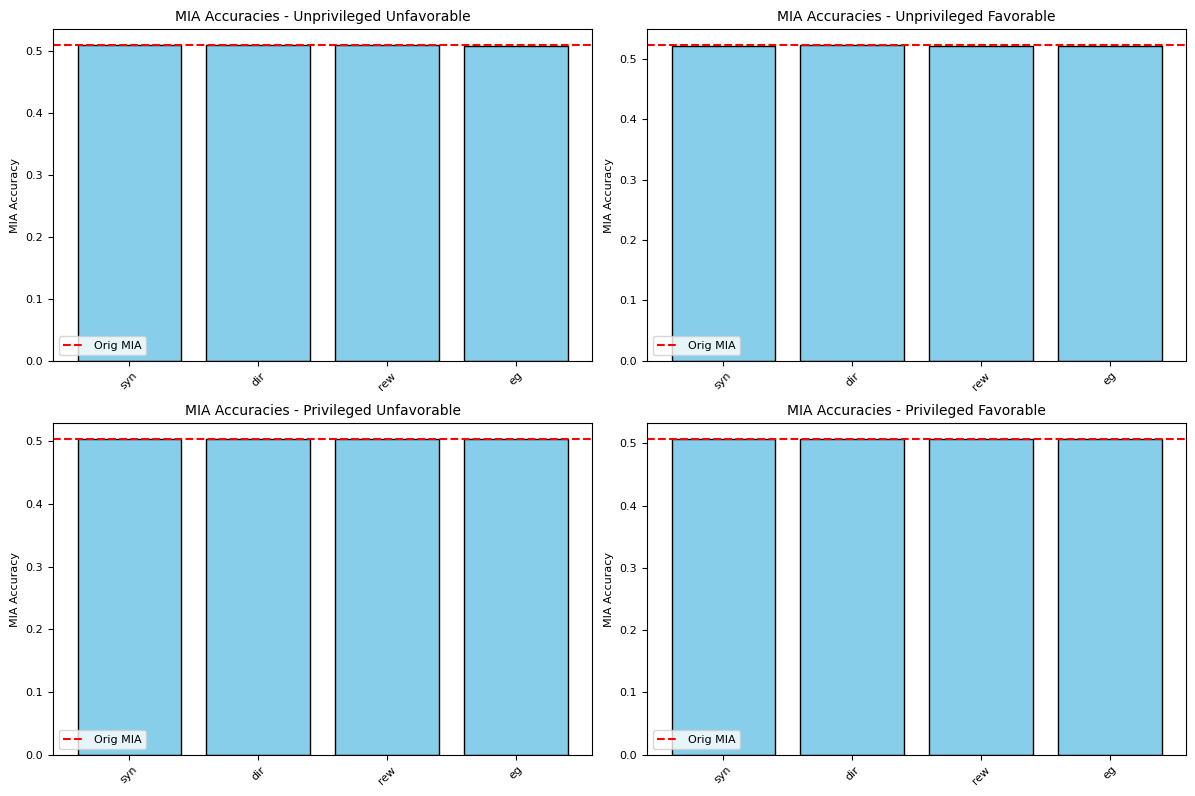

In [52]:
# Combine results into a list
all_results = [
    transf_mia_metrics_mean,
    dir_mia_metrics_mean,
    reweigh_mia_metrics_mean,
    eg_mia_metrics_mean
]

# Organize data for plotting
data = {subpopulations[key]: [results[key] for results in all_results] for key in subpopulations.keys()}
orig_values = orig_mia_metrics_mean

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
idx = 0

for key, value in subpopulations.items():
    accuracies = data[value]
    ax = axes[idx]
    
    # Plot bar chart (excluding 'orig')
    ax.bar(fairness_methods, accuracies, color='skyblue', edgecolor='black')
    
    # Add dashed line for 'orig' MIA accuracy
    ax.axhline(orig_values[key], color='red', linestyle='--', label='Orig MIA')
    
    # Title and labels
    ax.set_title(f"MIA Accuracies - {value}", fontsize=10)
    ax.set_ylabel("MIA Accuracy")
    ax.set_xticks(np.arange(len(fairness_methods)))
    ax.set_xticklabels(fairness_methods, rotation=45)
    ax.legend()
    
    idx = idx + 1

plt.tight_layout()
plt.show()

### Visualizing using novel technique

In [53]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [54]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [55]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.503010
1,orig,entire_dataset_mia_privacy_risk,0.503624
2,orig,entire_dataset_mia_privacy_risk,0.503665
3,orig,entire_dataset_mia_privacy_risk,0.502784
4,orig,entire_dataset_mia_privacy_risk,0.503153
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.507408
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.504297
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.504772
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.506370


In [56]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.503010
1,orig,entire_dataset_mia_privacy_risk,0.503624
2,orig,entire_dataset_mia_privacy_risk,0.503665
3,orig,entire_dataset_mia_privacy_risk,0.502784
4,orig,entire_dataset_mia_privacy_risk,0.503153
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.507408
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.504297
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.504772
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.506370


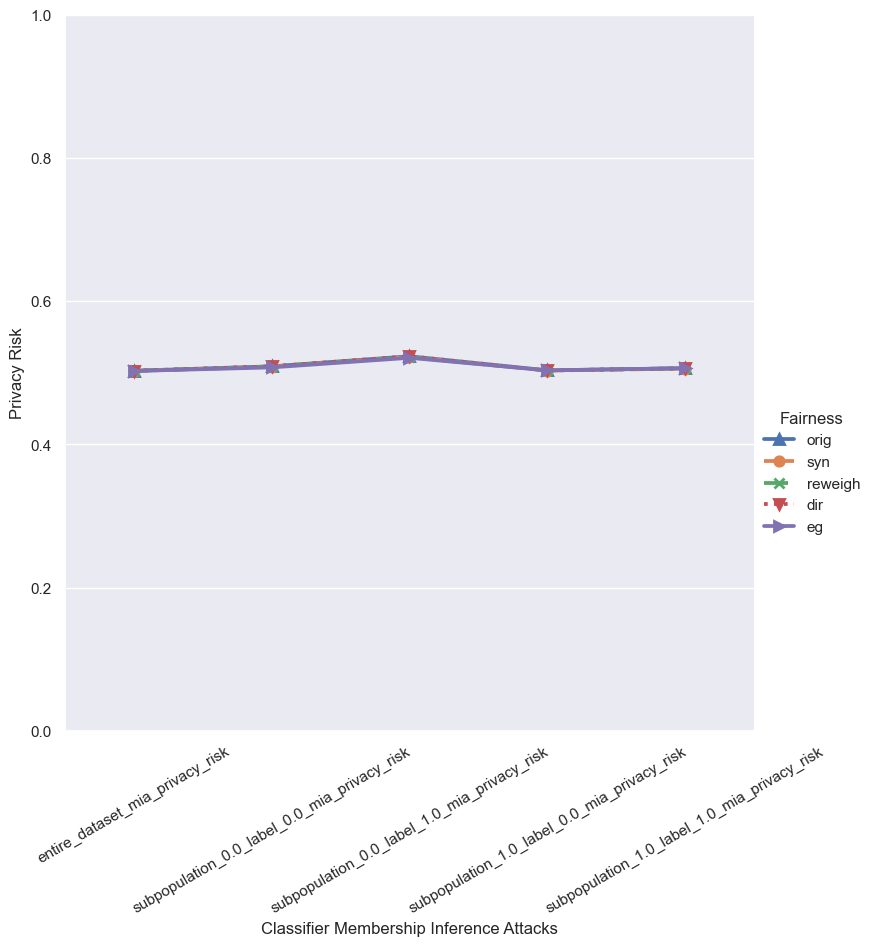

In [57]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [58]:
from sklearn.metrics import RocCurveDisplay, auc

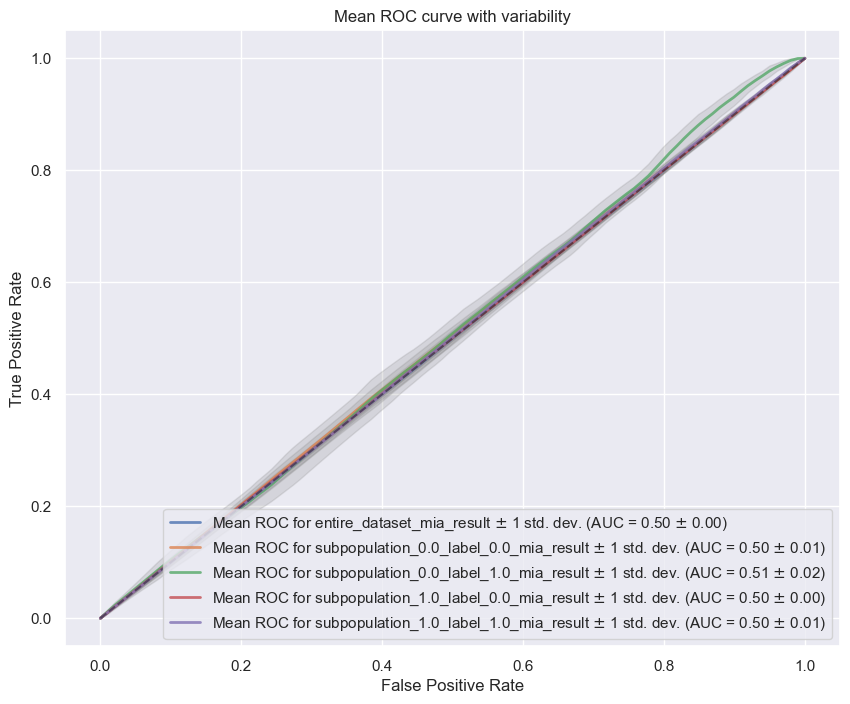

In [59]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -1.4390267117350617
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.31
  Test Accuracy (TNR): 0.70
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.08004270767353637
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.28
  Test Accuracy (TNR): 0.73
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.06431204621870032
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 24421, Test = 24421
  AUC: 0.50
  Privacy

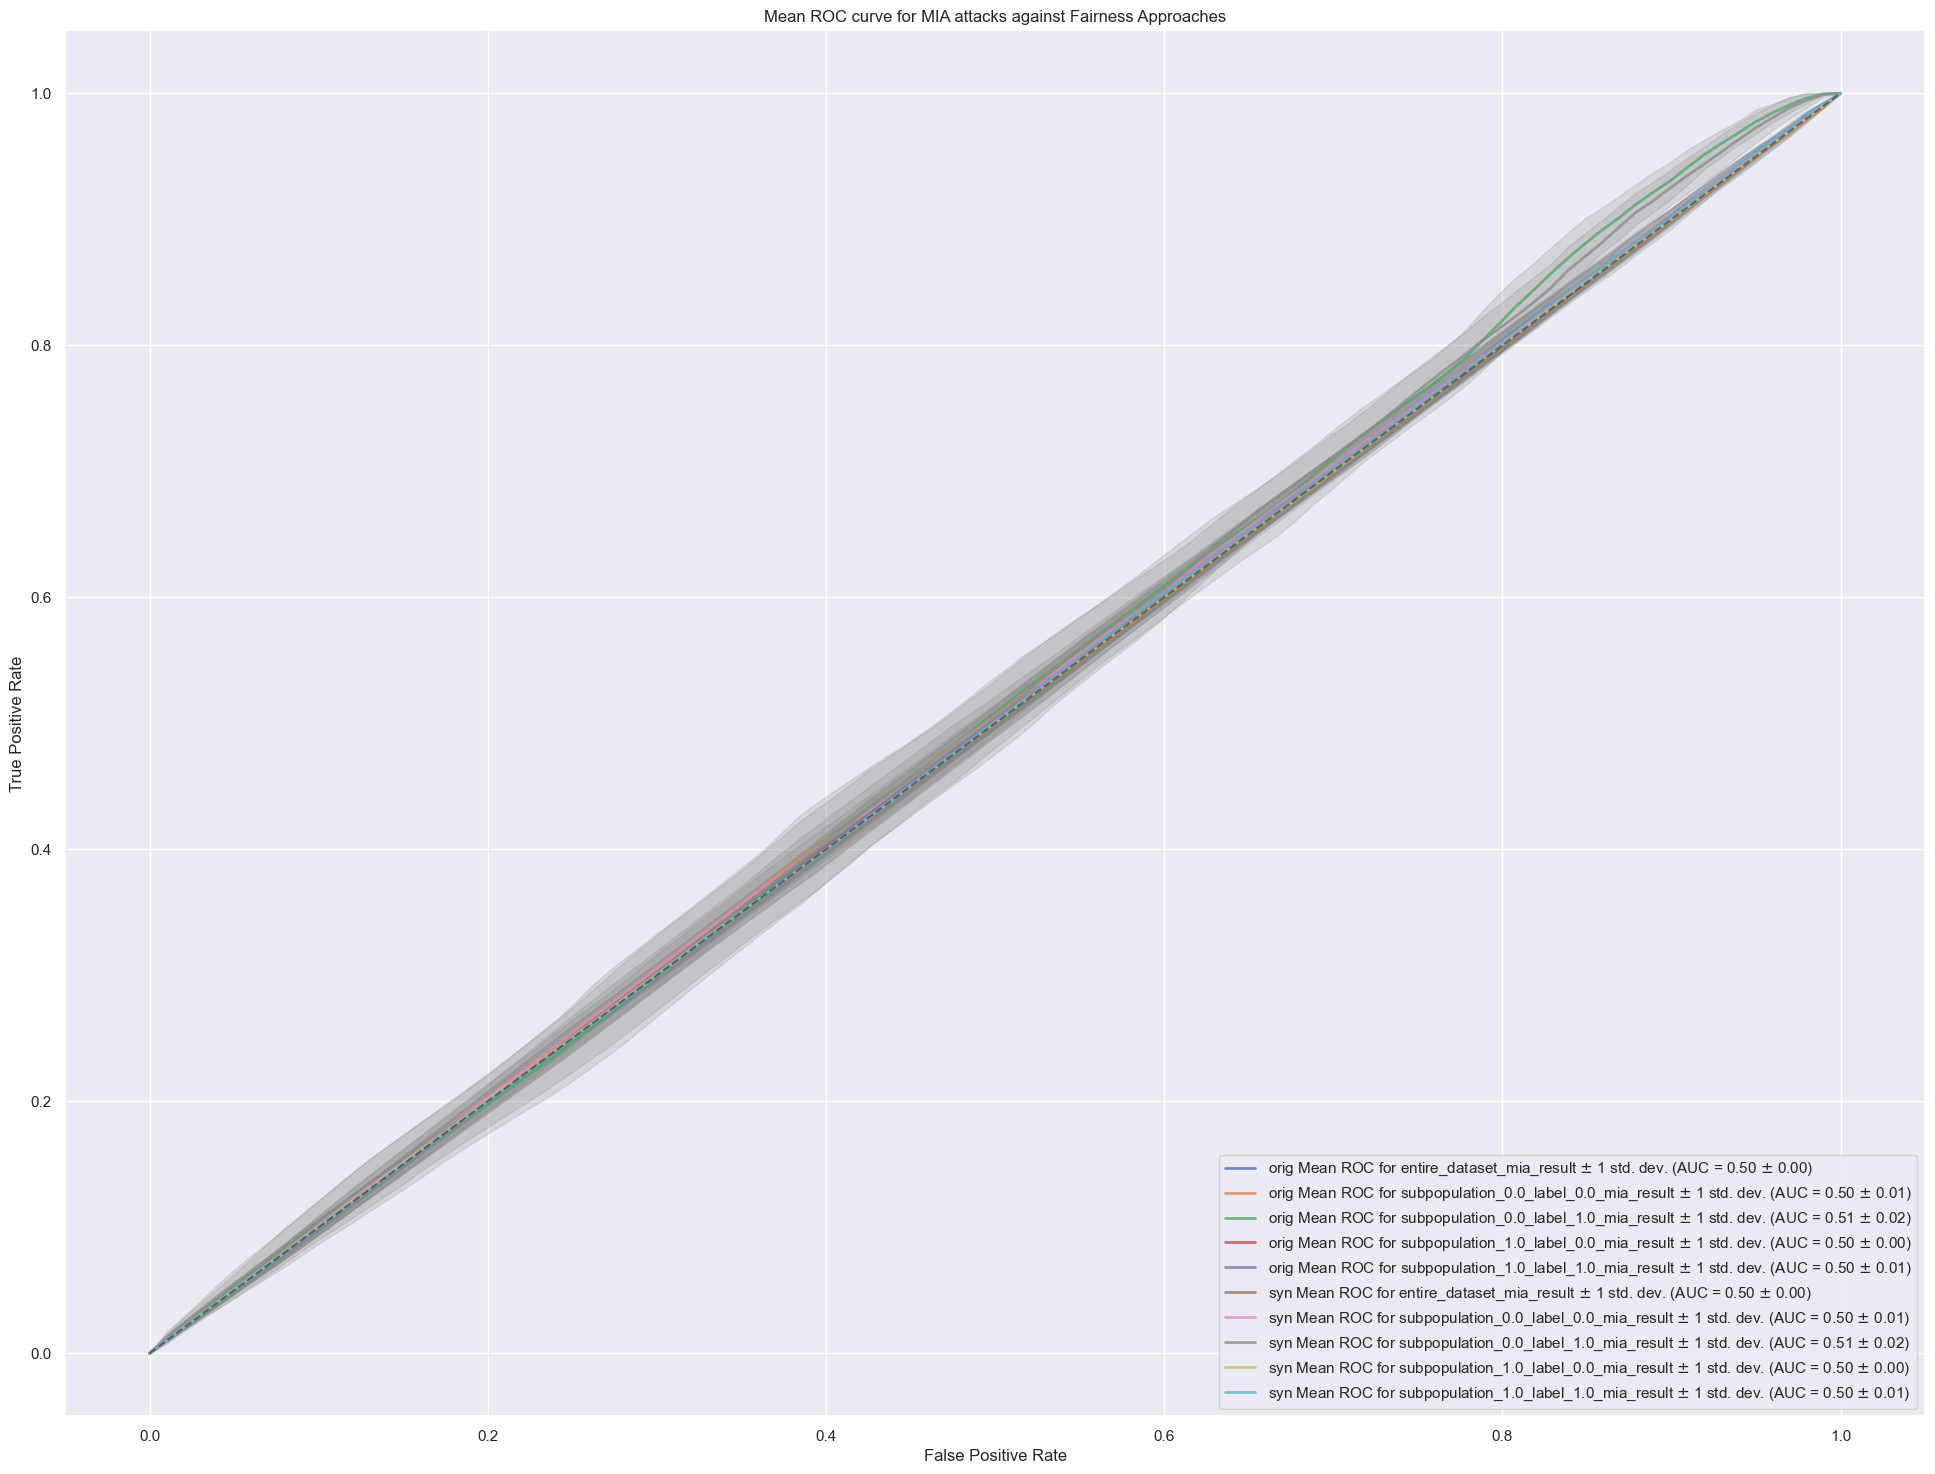

In [60]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

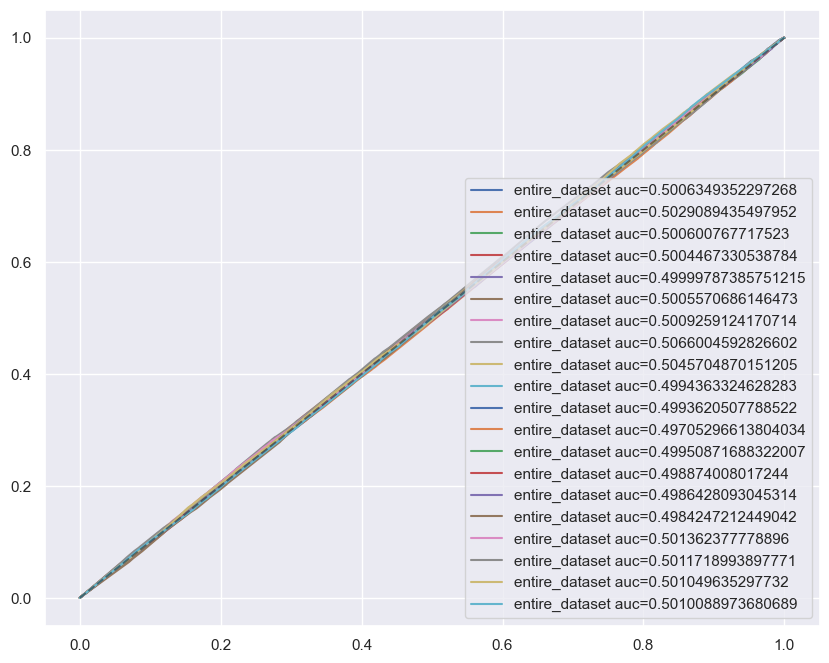

In [61]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [62]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [63]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.500657,0.501406,0.502958,0.504223,0.509640,0.500642,0.501973
syn,0.500338,0.501001,0.502407,0.503813,0.509071,0.500366,0.501413
dir,0.500657,0.501405,0.502962,0.504214,0.509692,0.500641,0.501973
rew,0.500370,0.501155,0.502537,0.503929,0.508772,0.500633,0.501954
egr,0.500078,0.500662,0.502472,0.501662,0.504971,0.500657,0.501837


<Axes: xlabel='Classifier MIA Attacks'>

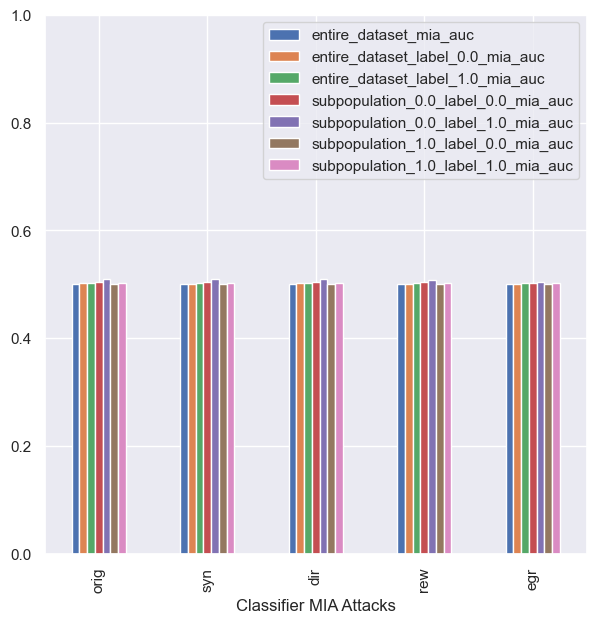

In [64]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [65]:
# Creating data structures to plot point categorical plot from seaborn

In [66]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [67]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.00601940952458957],
 ['orig', 'entire_dataset', 0.007247860447975152],
 ['orig', 'entire_dataset', 0.007329757176200824],
 ['orig', 'entire_dataset', 0.0055689775193480395],
 ['orig', 'entire_dataset', 0.006306048073379478],
 ['orig', 'entire_dataset', 0.004709061872978149],
 ['orig', 'entire_dataset', 0.00360345604193113],
 ['orig', 'entire_dataset', 0.012366405962081828],
 ['orig', 'entire_dataset', 0.009786659022972044],
 ['orig', 'entire_dataset', 0.003971991318946794],
 ['orig', 'entire_dataset', 0.004627165144752476],
 ['orig', 'entire_dataset', 0.007657344089103679],
 ['orig', 'entire_dataset', 0.003562507677818294],
 ['orig', 'entire_dataset', 0.005691822611686659],
 ['orig', 'entire_dataset', 0.005487080791122367],
 ['orig', 'entire_dataset', 0.006142254616928078],
 ['orig', 'entire_dataset', 0.007739240817329351],
 ['orig', 'entire_dataset', 0.0061832029810409],
 ['orig', 'entire_dataset', 0.006674583350395141],
 ['orig', 'entire_dataset', 0.0089

In [68]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.006019
1,orig,entire_dataset,0.007248
2,orig,entire_dataset,0.007330
3,orig,entire_dataset,0.005569
4,orig,entire_dataset,0.006306
...,...,...,...
695,egr,subpopulation_1.0_label_1.0,0.014817
696,egr,subpopulation_1.0_label_1.0,0.010278
697,egr,subpopulation_1.0_label_1.0,0.020980
698,egr,subpopulation_1.0_label_1.0,0.012740


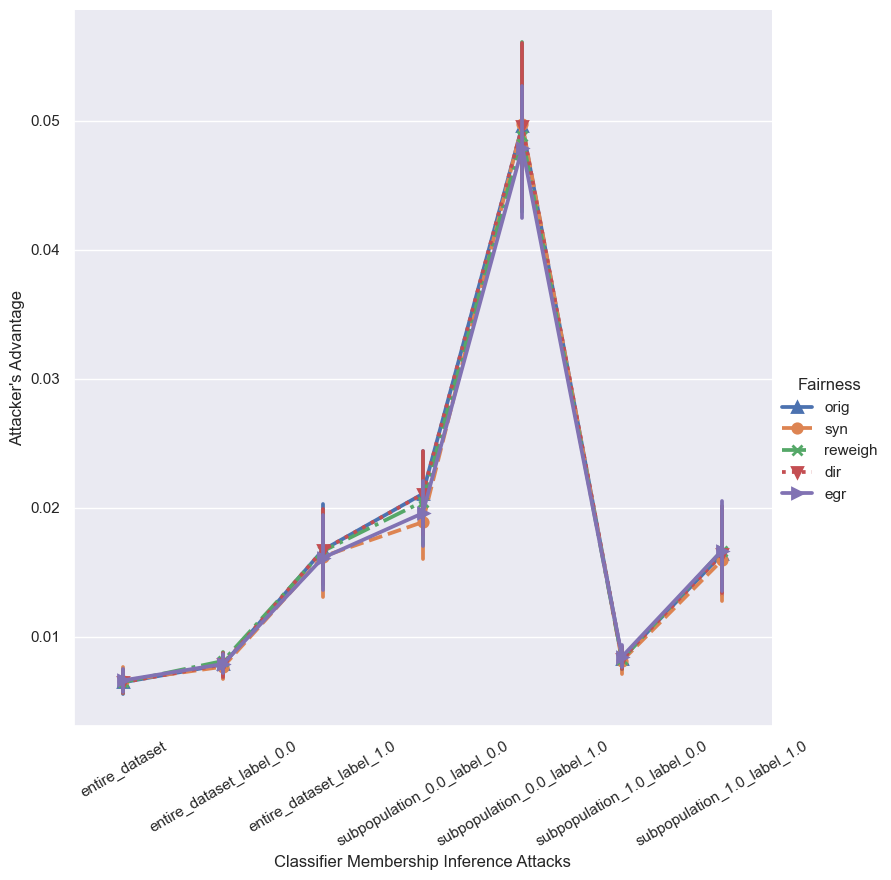

In [69]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


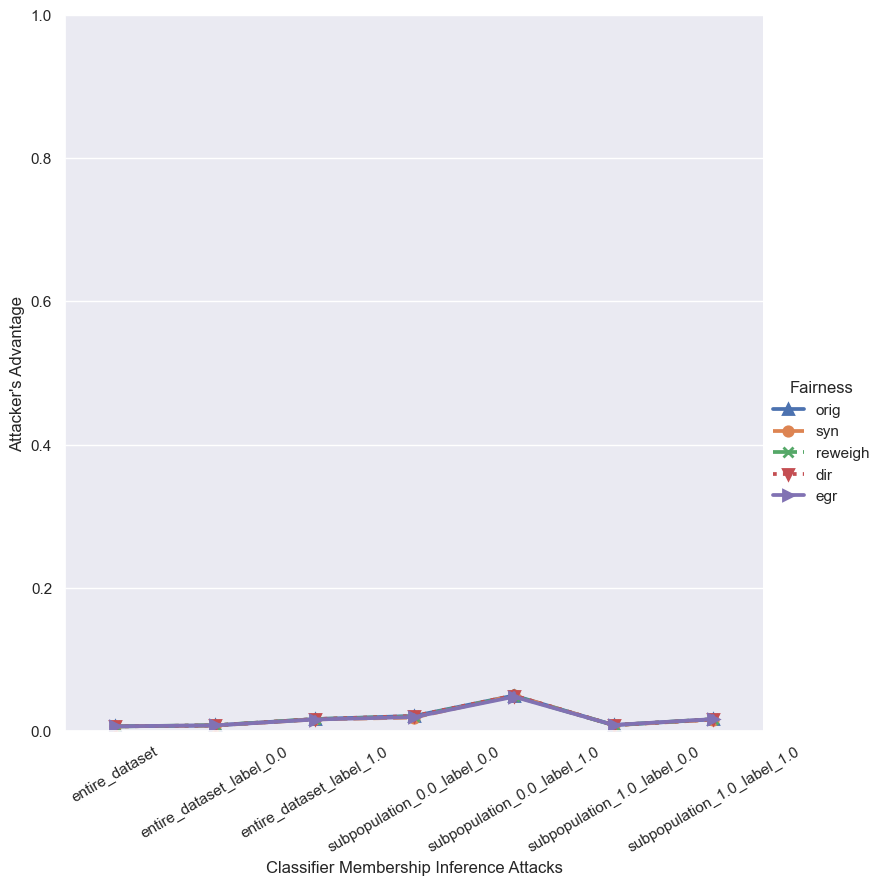

In [70]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [71]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.006019,0.005280,0.017638,0.016594,0.059369,0.009085,0.017845
1,0.007248,0.007491,0.020412,0.013206,0.072321,0.007601,0.021064
2,0.007330,0.010555,0.013693,0.009511,0.065778,0.011598,0.017114
3,0.005569,0.010053,0.010327,0.016117,0.041215,0.007780,0.010226
4,0.006306,0.010578,0.014090,0.032280,0.050454,0.009206,0.017743
5,0.004709,0.005695,0.009802,0.013350,0.035026,0.006216,0.010329
6,0.003603,0.004135,0.017003,0.018984,0.085642,0.006061,0.008645
7,0.012366,0.011029,0.021282,0.025386,0.054559,0.008342,0.019803
8,0.009787,0.009232,0.038664,0.011743,0.047784,0.011252,0.041033
9,0.003972,0.009060,0.013995,0.022633,0.032391,0.008529,0.012308


In [72]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [73]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.006482,0.007862,0.016729,0.021076,0.049600,0.008308,0.016391
syn,0.006609,0.007688,0.016228,0.018890,0.049726,0.008147,0.015923
dir,0.006484,0.007865,0.016729,0.021056,0.049600,0.008308,0.016391
rew,0.006503,0.008136,0.016642,0.020476,0.048795,0.008252,0.016676
egr,0.006632,0.007901,0.016129,0.019582,0.047906,0.008466,0.016673


<Axes: xlabel='Classifier MIA Attacks'>

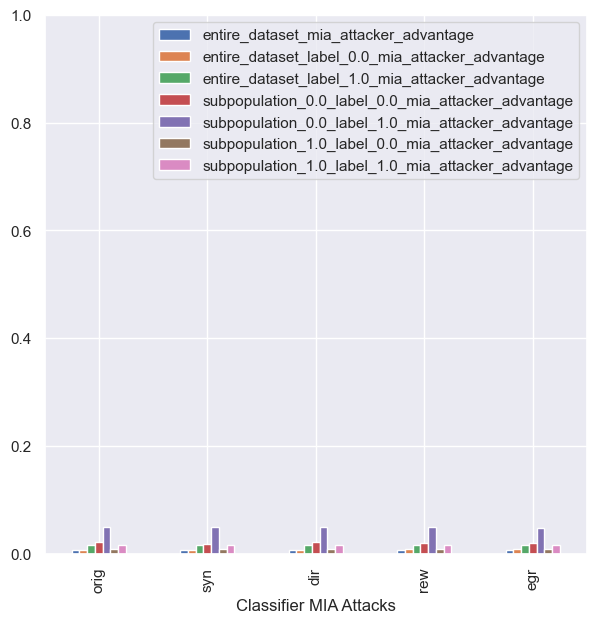

In [74]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [75]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [76]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5018664909969258],
 ['orig', 'entire_dataset', 0.5116169913165923],
 ['orig', 'entire_dataset', 0.5089596148702862],
 ['orig', 'entire_dataset', 0.5033765676921428],
 ['orig', 'entire_dataset', 0.506860371267151],
 ['orig', 'entire_dataset', 0.5069030168740413],
 ['orig', 'entire_dataset', 0.5019785189372526],
 ['orig', 'entire_dataset', 0.5122961428941237],
 ['orig', 'entire_dataset', 0.51172540285602],
 ['orig', 'entire_dataset', 0.5070476190476191],
 ['orig', 'entire_dataset', 0.5027207827866806],
 ['orig', 'entire_dataset', 0.5124103695532267],
 ['orig', 'entire_dataset', 0.5041828679156356],
 ['orig', 'entire_dataset', 0.5138513513513514],
 ['orig', 'entire_dataset', 0.502131691141639],
 ['orig', 'entire_dataset', 0.5020109424254502],
 ['orig', 'entire_dataset', 0.5112799810021373],
 ['orig', 'entire_dataset', 0.5198931116389549],
 ['orig', 'entire_dataset', 0.5099959747752583],
 ['orig', 'entire_dataset', 0.5081521739130435],
 ['orig', 'entire_datase

In [77]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.501866
1,orig,entire_dataset,0.511617
2,orig,entire_dataset,0.508960
3,orig,entire_dataset,0.503377
4,orig,entire_dataset,0.506860
...,...,...,...
695,egr,subpopulation_1.0_label_1.0,0.523913
696,egr,subpopulation_1.0_label_1.0,0.502895
697,egr,subpopulation_1.0_label_1.0,0.507977
698,egr,subpopulation_1.0_label_1.0,0.509996


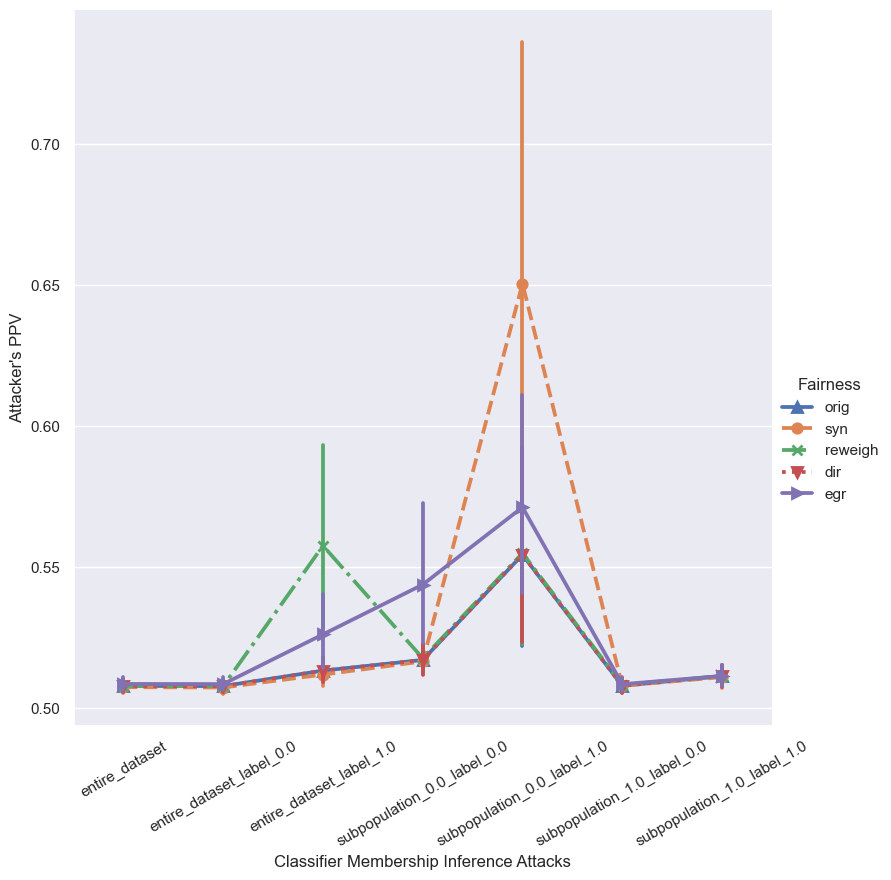

In [78]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )
